In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import io
import cv2
from PIL import Image, ImageFile
# import tensorflow as tf


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.platform import gfile

import numpy as np
import os
import pickle
import pandas as pd
import sys
import math
import multiprocessing as mp
import json
import requests
ImageFile.LOAD_TRUNCATED_IMAGES = True
cores = mp.cpu_count()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
WORK_DIR = '/content/drive/My Drive/Projects/FR/1/'
MODEL_DIR = '/content/drive/My Drive/Courses/Machine Learning Lab/'

## Configuration

In [4]:

#****************************
#*******FACE DETECTION*******
#****************************
# TENSORFLOW FACE MODEL DETECTION MODEL FILE
PATH_TO_FACE_DETECTION_MODEL = MODEL_DIR + 'frozen_inference_graph_face.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'face_label_map.pbtxt'
# Haar cascade file path
CASCADE_FILE_PATH = MODEL_DIR + 'haarcascade_frontalface_default.xml'
# Face Detection Confidence
FACE_DETECTION_CONFIDENCE = 0.50
# Number of classes
NUM_CLASSES = 2
# FRACTION OF GPU MEMORY TO USE FOR DETECTION
FRACTION_GPU_MEMORY_DETECTION = 0.45
#******************************
#*******FACE RECOGNITION*******
#******************************
# PATH TO FACE ENCODINGS FILE
PATH_TO_FACE_ENCODINGS_FILE = MODEL_DIR + 'encodings.pickle'
# TENSORFLOW FACE MODEL RECOGNITION MODEL FILE
PATH_TO_FACE_RECOGNITION_MODEL = MODEL_DIR + '20170512-110547.pb'
# FRACTION OF GPU MEMORY TO USE FOR RECOGNITION
FRACTION_GPU_MEMORY_RECOGNITION = 0.45
# FACE RECOGNITION DISTANCE THRESHOLD
DISTANCE_THRESHOLD = 1
# Face recognition percentage threshold
PERCENTGE_THRESHOLD = 70
# Input Image Size
INPUT_IMAGE_SIZE = 160
# minimum face width and height
MIN_FACE_SIZE = 40
# BLURR THRESHOLD
BLURR_THRESHOLD = 100
# known person list for validation
KNOWN_PERSONS_VALIDATION = []

## Model Downloads
* If they do not exist in google drive

In [5]:
def download_file_from_google_drive(id, destination='.'):
    URL = "https://docs.google.com/uc?export=download"

    # session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [6]:
# file_ids = {'faceEmbedding':'18RxJk9Pk0Mic-FpM5tDlZbdt8w6C0GzW', 'faceDetection':'1WAP6_EiQyHdKaGtuql6PHSFKgYf3cRBw', 'faceDetectionpb':'1klwtdeCw0eG49_q_tVPaW9CmYhjV5V7A', 'haarFrontalFace':'1ZpBm_4wmJCk_wm0DYn9J-pNnF3HgIVty'}
# dfive_paths = [PATH_TO_FACE_RECOGNITION_MODEL, PATH_TO_FACE_DETECTION_MODEL, PATH_TO_LABELS, CASCADE_FILE_PATH]
# file_ids = {PATH_TO_FACE_RECOGNITION_MODEL:'18RxJk9Pk0Mic-FpM5tDlZbdt8w6C0GzW', PATH_TO_FACE_DETECTION_MODEL:'1WAP6_EiQyHdKaGtuql6PHSFKgYf3cRBw', PATH_TO_LABELS:'1klwtdeCw0eG49_q_tVPaW9CmYhjV5V7A', CASCADE_FILE_PATH:'1ZpBm_4wmJCk_wm0DYn9J-pNnF3HgIVty'}
# if not os.path.exists(MODEL_DIR + 'encodings.pickle'):
#     PATH_TO_FACE_ENCODINGS_FILE = 'encodings.pickle'
# for path in file_ids.keys():
#     if not os.path.exists(path):
#         # setting the destination file path to current directory
#         destination = path.split('/')[-1]
#         if not os.path.exists(destination):
#             download_file_from_google_drive(file_ids[path], destination)

In [7]:
WORK_DIR = './'
MODEL_DIR = './'
if os.path.exists(MODEL_DIR + 'frozen_inference_graph_face.pb'):
    PATH_TO_FACE_DETECTION_MODEL = MODEL_DIR + 'frozen_inference_graph_face.pb'
if os.path.exists(MODEL_DIR + 'haarcascade_frontalface_default.xml'):
    CASCADE_FILE_PATH = MODEL_DIR + 'haarcascade_frontalface_default.xml'
if os.path.exists(MODEL_DIR + 'face_label_map.pbtxt'):
    PATH_TO_LABELS = 'face_label_map.pbtxt'
if os.path.exists(MODEL_DIR + '20170512-110547.pb'):
    PATH_TO_FACE_RECOGNITION_MODEL = MODEL_DIR + '20170512-110547.pb'

## Image Preprocessing

In [8]:
from ImageOptimization import ImageOptimization











## Face Detection

In [9]:
from TensoflowFaceDector import TensoflowFaceDector
from FacePose import FacePose






## Face Embeddings

In [10]:
# from TensorflowFaceRecognition import TensorflowFaceRecognition

class TensorflowFaceRecognition(object):

    def __init__(self, MODEL_PATH):
        print('Face Recognition model loading...')
        self.recognition_graph = tf.Graph()
        with self.recognition_graph.as_default():
            model_exp = os.path.expanduser(MODEL_PATH)
            if os.path.isfile(model_exp):
                # print('Model filename: %s' % model_exp)
                with gfile.FastGFile(model_exp, 'rb') as f:
                    graph_def = tf.GraphDef()
                    graph_def.ParseFromString(f.read())
                    tf.import_graph_def(graph_def, input_map=None, name='')
                    # Get input and output tensors
                    self.images_placeholder = self.recognition_graph.get_tensor_by_name("input:0")
                    self.embeddings = self.recognition_graph.get_tensor_by_name("embeddings:0")
                    self.phase_train_placeholder = self.recognition_graph.get_tensor_by_name("phase_train:0")
                    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=config.FRACTION_GPU_MEMORY_RECOGNITION)
                    # # creating the tensorflow session
                    # self.sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
                    self.sess = tf.Session()
                    print('Face Recognition model loaded!')
                    # writer = tf.summary.FileWriter('./tf_logs/face_recognition', self.sess.graph)
            else:
                print('Model directory: %s' % model_exp)
                meta_file, ckpt_file = get_model_filenames(model_exp)

                print('Metagraph file: %s' % meta_file)
                print('Checkpoint file: %s' % ckpt_file)

                saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file), input_map=input_map)
                saver.restore(self.recognition_graph.get_default_session(), os.path.join(model_exp, ckpt_file))

    def getEmbedding(self, resized, input_image_size=INPUT_IMAGE_SIZE):
        """Calculating the embedding for a face patch"""
        reshaped = resized.reshape(-1, input_image_size, input_image_size, 3)
        feed_dict = {self.images_placeholder: reshaped, self.phase_train_placeholder: False}
        embedding = self.sess.run(self.embeddings, feed_dict=feed_dict)
        return embedding
    
    def findCosineSimilarity(self, vector_1, vector_2):
        a = np.matmul(np.transpose(vector_1), vector_2)
        b = np.sum(np.multiply(vector_1, vector_2))
        c = np.sum(np.multiply(vector_1, vector_2))
        return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
    
    def l2_normalize(self, x):
        return x / np.sqrt(np.sum(np.multiply(x, x)))
    
    def prewhiten(self, x):
        """Normalzing the face patch"""
        mean = np.mean(x)
        std = np.std(x)
        std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
        y = np.multiply(np.subtract(x, mean), 1 / std_adj)
        return y

    def detect_face(self, img, thres=FACE_DETECTION_CONFIDENCE, input_image_size=INPUT_IMAGE_SIZE):
        h, w = img.shape[:2]
        bbs = []
        (boxes, scores, classes, num_detections) = tDetector.run(img)
        boxes = np.squeeze(boxes)
        classes = np.squeeze(classes).astype(np.int32)
        scores = np.squeeze(scores)
        for i in range(boxes.shape[0]):
            if scores is None or scores[i] > thres:
                box = tuple(boxes[i].tolist())
                ymin, xmin, ymax, xmax = box
                left, right, top, bottom = xmin * w, xmax * w, ymin * h, ymax * h
                left, right, top, bottom = int(left), int(right), int(top), int(bottom)
                if right - left >= MIN_FACE_SIZE and bottom - top >= MIN_FACE_SIZE:
                    bbs.append([int(left), int(top), int(right), int(bottom)])
        return bbs

    def getFace(self, img, thres=FACE_DETECTION_CONFIDENCE, input_image_size=INPUT_IMAGE_SIZE):
        faces = []
        bbs = self.detect_face(img)
        for left, top, right, bottom in bbs:
            # cropping the face patch from the frame
            cropped = img[top:bottom, left:right, :]
            # resizing the cropped image to the input_image_size
            resized = cv2.resize(cropped, (input_image_size, input_image_size), interpolation=cv2.INTER_CUBIC)
            # normalizing the image
            prewhitened = self.prewhiten(resized)
            # making the output
            faces.append(
                {'face': resized, 'rect': (left, top, right, bottom),
                    'embeddings': self.getEmbedding(prewhitened)})
        return faces

In [11]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [12]:
print(PATH_TO_FACE_DETECTION_MODEL)

/content/drive/My Drive/Courses/Machine Learning Lab/frozen_inference_graph_face.pb


In [13]:

img_p = ImageOptimization()
facepose = FacePose(CASCADE_FILE_PATH)
tDetector = TensoflowFaceDector(PATH_TO_FACE_DETECTION_MODEL)
tRecognition = TensorflowFaceRecognition(PATH_TO_FACE_RECOGNITION_MODEL)

Face Detection model loading...
Face Detection model loaded!
Face Recognition model loading...
Instructions for updating:
Use tf.gfile.GFile.
Face Recognition model loaded!


## Loading & Matching Data

In [14]:
# from IdData import IdData
class IdData(object):
    """Keeps track of known identities and calculates id matches"""

    def __init__(self):
        # Initializing the parameters
        self.distance_threshold = DISTANCE_THRESHOLD
        self.names = []
        self.known_encodings = []

    def fetchKnownEncodings(self, path):
        """getting the known encoding from a pickle file"""
        try:
            if os.path.exists(path) and os.path.getsize(path) > 0:
                with open(path, 'rb') as fr:
                    [self.names, self.known_encodings] = pickle.load(fr)
        except Exception as e:
            print('Exception occured in reading from Pickle file:' + e)
    
    def saveEncoding(self, path, name, image):
        """saving known encoding to a pickle file"""
        try:
            data = tRecognition.getFace(image)
            print('Encodings successfully calculated!')
            if len(data) > 1:
                raise Exception('More than one person in the image found')
            if os.path.exists(path):
                with open(path, 'rb') as fr:
                    [self.names, self.known_encodings] = pickle.load(fr)
                    self.names.append(name)
                    self.known_encodings.append(data[0]['embeddings'][0])
                    with open(path, 'wb') as fw:
                        pickle.dump([self.names, self.known_encodings], fw, protocol=pickle.HIGHEST_PROTOCOL)
                    print('File saved')
            else:
                self.names.append(name)
                self.known_encodings.append(data[0]['embeddings'][0])
                with open(path, 'wb') as fw:
                    pickle.dump([self.names, self.known_encodings], fw, protocol=pickle.HIGHEST_PROTOCOL)
                print('File saved')
        except Exception as e:
            print('Exception occured in reading from Pickle file:' + e)
    
    def findPeople(self, features_arr, thres=0.5, percent_thres=PERCENTGE_THRESHOLD):
        """
        :param features_arr: a list of 128d Features of all faces on screen
        :param thres: distance threshold
        :param percent_thres: confidence percentage
        :return: person name and percentage
        """
        data_set = id_data.known_encodings
        known_persons = id_data.names
        returnRes = []
        for data in features_arr:
            result = "Unknown"
            smallest = sys.maxsize
            for (i, person_data) in enumerate(data_set):
                distance = np.sqrt(np.sum(np.square(person_data - data['embeddings'][0])))
                if distance < smallest:
                    smallest = distance
                    result = known_persons[i]
            percentage = min(100, 100 * thres / smallest)
            if percentage <= percent_thres:
                result = "Unknown"
            returnRes.append((result, percentage))
        return returnRes

## Initializing the classes

In [15]:
# must be done only once
id_data = IdData()



## Registration

In [16]:
# Additional Packages required for Face Registration purposes
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

In [17]:
def take_photo(filename, quality=0.8):
    
    img = cv2.imread(filename)
   
    return img

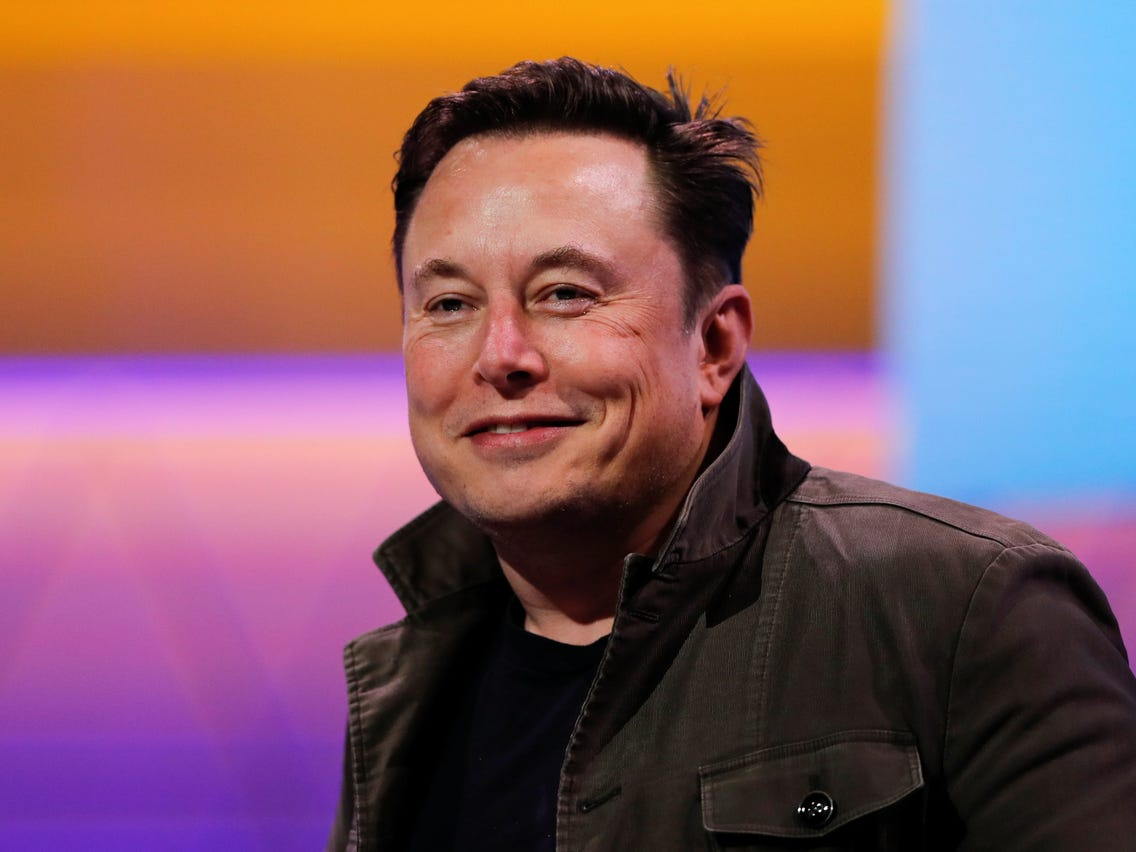

In [18]:
# take photo
# display photo

img = take_photo('elon musk.jpg')
cv2_imshow(img)

Enter your name: Elon Musk
Encodings successfully calculated!
File saved
Elon Musk has registered successfully!


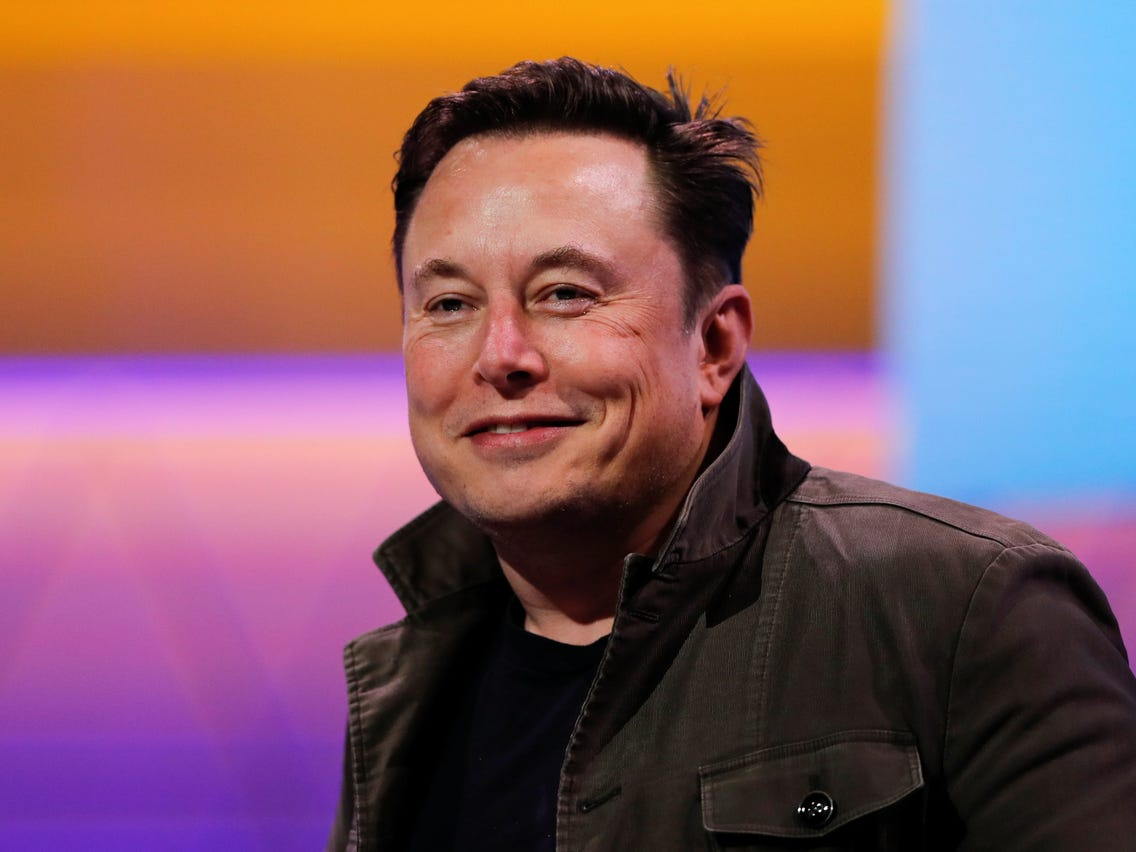

In [19]:
# enter name
name = input('Enter your name: ')

# calculate and save encoding
id_data.saveEncoding(PATH_TO_FACE_ENCODINGS_FILE, name, img)
print('{} has registered successfully!'.format(name))
cv2_imshow(img)


## Face Recognition Demo

In [20]:
# add known persons from the encoding file
id_data.fetchKnownEncodings(PATH_TO_FACE_ENCODINGS_FILE)

In [21]:
def draw_result_on_image(img, result):
    for person in result.keys():
        bb, confidence = result[person]['bb'], result[person]['confidence']
        if person == 'Unknown':
            cv2.rectangle(img, (bb[0], bb[1]), (bb[2], bb[3]), (0, 0, 255))
        else:
            cv2.rectangle(img, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0))
        cv2.putText(img, person + ': ' + str(confidence), (bb[0], bb[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return img

In [22]:
def recognize(img):
    # # converting the image to RGB
    img_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    # # Face recognition function
    faces = tRecognition.getFace(img_rgb)
    # # creating a dictionary for the results for our FR algo
    matching_person_dict = {}
    if not len(id_data.names):
        print('No persons registered in the database')
        return None
    if len(faces) > 0:
        recog_data = id_data.findPeople(faces)
        for name_dist, data in zip(recog_data, faces):
            bb = data['rect']
            matching_person_dict[name_dist[0]] = {'bb': bb,
                                                    'confidence': str(name_dist[1])}
            result_image = draw_result_on_image(img, matching_person_dict)
    else:
        print('No persons detected in the given image')
        return None
    # # json response:
    # # return json.dumps(matching_person_dict, cls=NumpyEncoder)
    return result_image, matching_person_dict

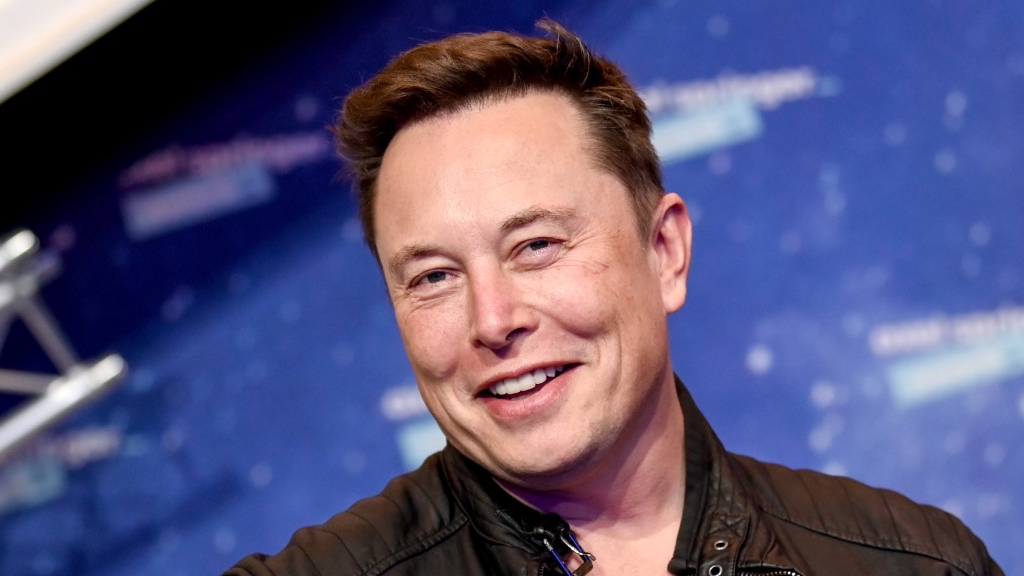

In [23]:
img_to_recognize = take_photo('elonmusk2.png')
cv2_imshow(img_to_recognize)

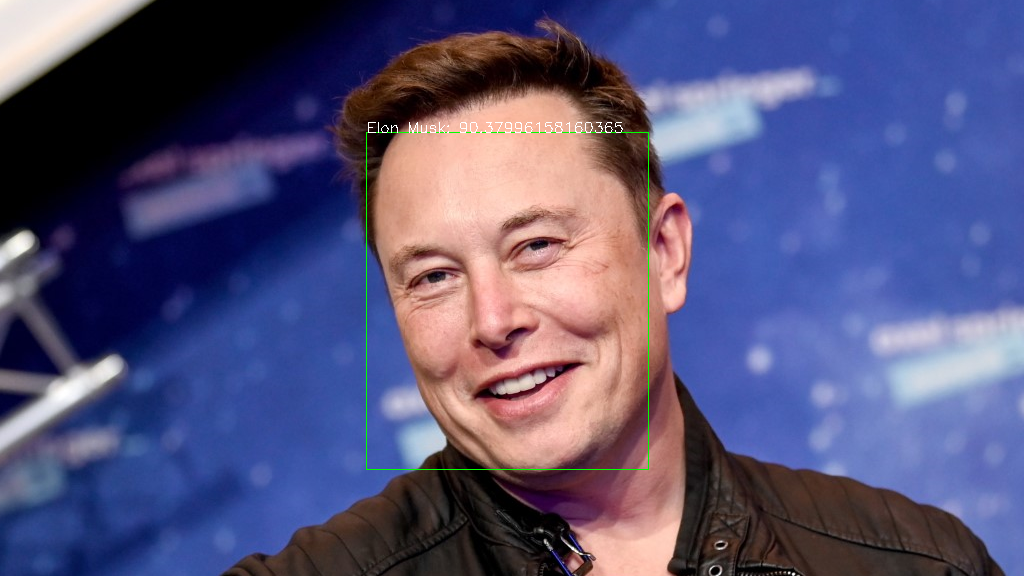


Result: {'Elon Musk': {'bb': (366, 132, 648, 469), 'confidence': '90.37996158160365'}}


In [24]:
# take photo
img_to_recognize = take_photo('elonmusk2.png')
# sending frame for recognition
result_image, result = recognize(img_to_recognize)
# display photo
cv2_imshow(result_image)
print('\nResult:', result)

# Emotion Analysis

In [25]:
import sys
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, add, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)


In [26]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
import copy

In [27]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def get_labels(dataset_name):
    if dataset_name == 'fer2013':
        return {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
                4: 'sad', 5: 'surprise', 6: 'neutral'}
    elif dataset_name == 'imdb':
        return {0: 'woman', 1: 'man'}
    elif dataset_name == 'KDEF':
        return {0: 'AN', 1: 'DI', 2: 'AF', 3: 'HA', 4: 'SA', 5: 'SU', 6: 'NE'}
    else:
        raise Exception('Invalid dataset name')

In [28]:
from FaceImage import FaceImage


In [31]:
face = FaceImage()

Loading age and gender detection model...
Loaded models
Loading emotion model...
Emotion model loaded


Face Recognition model loading...
Face Recognition model loaded!
Face Detection model loading...
Face Detection model loaded!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


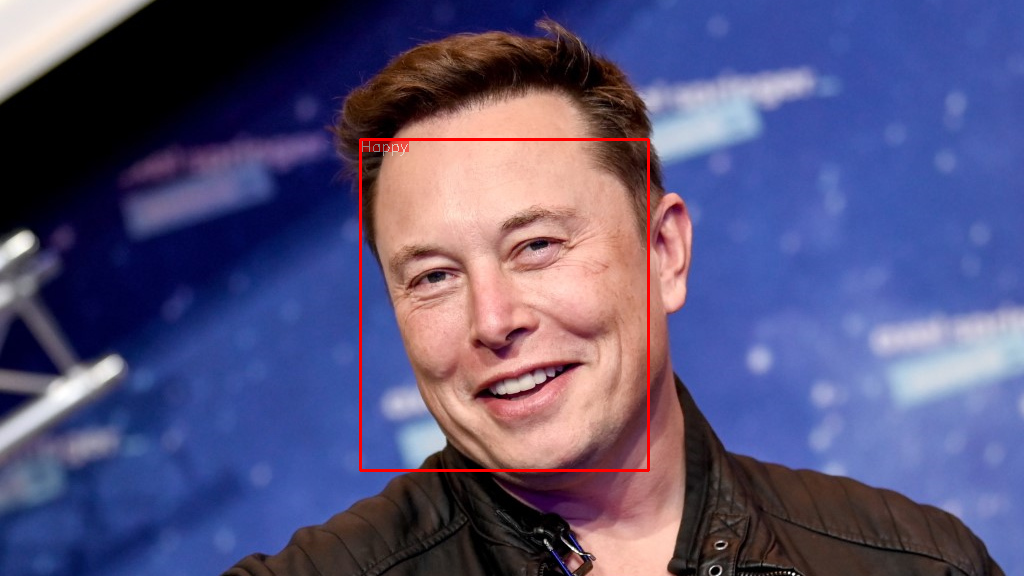

In [32]:
# take photo
img_to_analysis = take_photo('elonmusk2.png')
image_rgb = cv2.cvtColor(img_to_analysis, cv2.COLOR_BGR2RGB)
image = face.detect_face_char(image_rgb)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(image)